In [1]:
# Import libraries
import pandas_datareader as web
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

C:\Users\minhd\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


## Data Preprocessing

In [2]:
# Get the data
data = web.DataReader('MSFT', data_source='yahoo', start='2010-01-01', end='2020-04-30')
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,31.100000,30.590000,30.620001,30.950001,38409100.0,24.294369
2010-01-05,31.100000,30.639999,30.850000,30.959999,49749600.0,24.302216
2010-01-06,31.080000,30.520000,30.879999,30.770000,58182400.0,24.153070
2010-01-07,30.700001,30.190001,30.629999,30.450001,50559700.0,23.901886
2010-01-08,30.879999,30.240000,30.280001,30.660000,51197400.0,24.066734
...,...,...,...,...,...,...
2020-04-24,174.559998,170.710007,172.059998,174.550003,34305300.0,174.550003
2020-04-27,176.899994,173.300003,176.589996,174.050003,33194400.0,174.050003
2020-04-28,175.669998,169.389999,175.589996,169.809998,34392700.0,169.809998


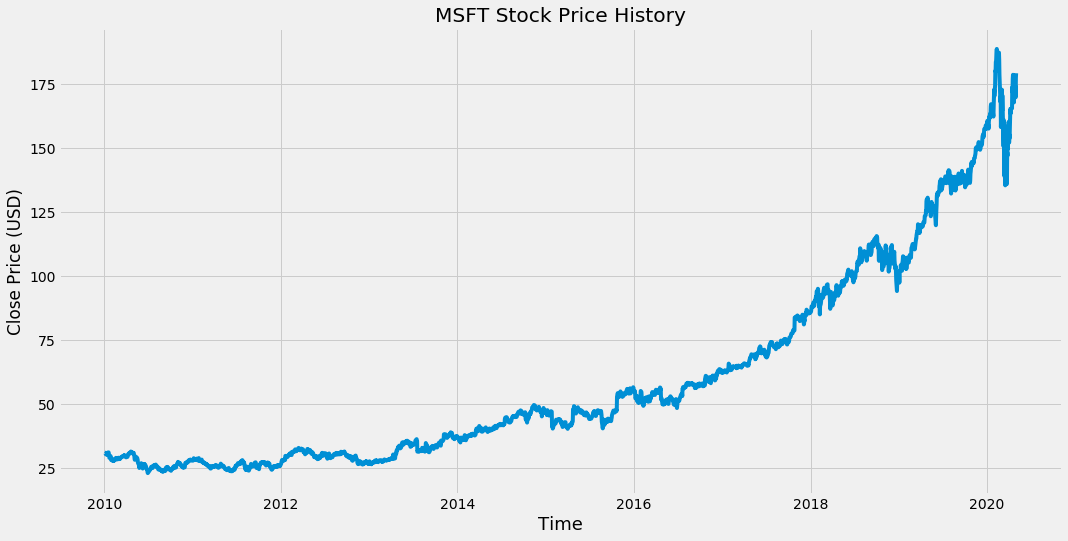

In [3]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('MSFT Stock Price History')
plt.plot(data['Close'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price (USD)')
plt.show()

In [4]:
# Create the training dataset that includes only MSFT stock prices pre-2020
data_train = data.loc[:'2020-01-01']
data_train

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,31.100000,30.590000,30.620001,30.950001,38409100.0,24.294369
2010-01-05,31.100000,30.639999,30.850000,30.959999,49749600.0,24.302216
2010-01-06,31.080000,30.520000,30.879999,30.770000,58182400.0,24.153070
2010-01-07,30.700001,30.190001,30.629999,30.450001,50559700.0,23.901886
2010-01-08,30.879999,30.240000,30.280001,30.660000,51197400.0,24.066734
...,...,...,...,...,...,...
2019-12-24,157.710007,157.119995,157.479996,157.380005,8989200.0,156.951309
2019-12-26,158.729996,157.399994,157.559998,158.669998,14520600.0,158.237793
2019-12-27,159.550003,158.220001,159.449997,158.960007,18412800.0,158.527008


In [5]:
# Create the testing dataset that includes only MSFT stock prices in 2020
data_test = data.loc['2020-01-01':]
data_test

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,160.729996,158.330002,158.779999,160.619995,22622100.0,160.182480
2020-01-03,159.949997,158.059998,158.320007,158.619995,21116200.0,158.187927
2020-01-06,159.100006,156.509995,157.080002,159.029999,20813700.0,158.596817
2020-01-07,159.669998,157.320007,159.320007,157.580002,21634100.0,157.150772
2020-01-08,160.800003,157.949997,158.929993,160.089996,27746500.0,159.653915
...,...,...,...,...,...,...
2020-04-24,174.559998,170.710007,172.059998,174.550003,34305300.0,174.550003
2020-04-27,176.899994,173.300003,176.589996,174.050003,33194400.0,174.050003
2020-04-28,175.669998,169.389999,175.589996,169.809998,34392700.0,169.809998


In [6]:
# Create the training dataset that only includes the closing price
dataset_train = data_train.filter(['Close'])
training_set = dataset_train.values
training_set

array([[ 30.95000076],
       [ 30.95999908],
       [ 30.77000046],
       ...,
       [158.96000671],
       [157.58999634],
       [157.69999695]])

In [7]:
# Create the training dataset that only includes the closing price
dataset_test = data_test.filter(['Close'])
testing_set = dataset_test.values
testing_set

array([[160.61999512],
       [158.61999512],
       [159.02999878],
       [157.58000183],
       [160.08999634],
       [162.08999634],
       [161.33999634],
       [163.27999878],
       [162.13000488],
       [163.17999268],
       [166.16999817],
       [167.1000061 ],
       [166.5       ],
       [165.69999695],
       [166.72000122],
       [165.03999329],
       [162.27999878],
       [165.46000671],
       [168.03999329],
       [172.77999878],
       [170.22999573],
       [174.38000488],
       [180.11999512],
       [179.8999939 ],
       [183.63000488],
       [183.88999939],
       [188.69999695],
       [184.44000244],
       [184.71000671],
       [183.71000671],
       [185.3500061 ],
       [187.22999573],
       [187.27999878],
       [184.41999817],
       [178.58999634],
       [170.88999939],
       [168.07000732],
       [170.16999817],
       [158.17999268],
       [162.00999451],
       [172.78999329],
       [164.50999451],
       [170.55000305],
       [166

In [8]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [9]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the RNN 

In [11]:
# Initialising the RNN
regressor = Sequential()

In [12]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [13]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [14]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [15]:
# Adding the final LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [16]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [17]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [18]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 300, batch_size = 32)

Epoch 1/300
2456/2456 [==============================] - 8s 3ms/step - loss: 0.0071
Epoch 2/300
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0017
Epoch 3/300
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0017
Epoch 4/300
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0018
Epoch 5/300
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0015
Epoch 6/300
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0013
Epoch 7/300
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0014
Epoch 8/300
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0012A: 0s - loss: 
Epoch 9/300
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0012
Epoch 10/300
2456/2456 [==============================] - 6s 3ms/step - loss: 0.0010
Epoch 11/300
2456/2456 [==============================] - 6s 3ms/step - loss: 0.0010
Epoch 12/300
2456/2456 [==============================] - 7s

2456/2456 [==============================] - 7s 3ms/step - loss: 7.9461e-04A: 1s - loss: 8.4960e- - ETA: 1s - loss: 8.5273e - ETA: 1s - 
Epoch 92/300
2456/2456 [==============================] - 6s 3ms/step - loss: 7.4377e-04
Epoch 93/300
2456/2456 [==============================] - 7s 3ms/step - loss: 6.1744e-04
Epoch 94/300
2456/2456 [==============================] - 6s 3ms/step - loss: 5.9801e-04
Epoch 95/300
2456/2456 [==============================] - 6s 3ms/step - loss: 5.7814e-04
Epoch 96/300
2456/2456 [==============================] - 7s 3ms/step - loss: 6.7367e-04
Epoch 97/300
2456/2456 [==============================] - 7s 3ms/step - loss: 6.9776e-04
Epoch 98/300
2456/2456 [==============================] - 7s 3ms/step - loss: 6.2140e-04
Epoch 99/300
2456/2456 [==============================] - 6s 3ms/step - loss: 5.7748e-04
Epoch 100/300
2456/2456 [==============================] - 6s 3ms/step - loss: 7.3604e-04
Epoch 101/300
2456/2456 [==============================] - 7s

2456/2456 [==============================] - 7s 3ms/step - loss: 5.8313e-04
Epoch 182/300
2456/2456 [==============================] - 6s 3ms/step - loss: 5.7480e-04
Epoch 183/300
2456/2456 [==============================] - 6s 3ms/step - loss: 5.2710e-04
Epoch 184/300
2456/2456 [==============================] - 7s 3ms/step - loss: 5.4155e-04
Epoch 185/300
2456/2456 [==============================] - 6s 3ms/step - loss: 5.5175e-04
Epoch 186/300
2456/2456 [==============================] - 7s 3ms/step - loss: 5.9278e-04
Epoch 187/300
2456/2456 [==============================] - 7s 3ms/step - loss: 6.0339e-04
Epoch 188/300
2456/2456 [==============================] - 7s 3ms/step - loss: 5.0942e-04
Epoch 189/300
2456/2456 [==============================] - 7s 3ms/step - loss: 6.5092e-04
Epoch 190/300
2456/2456 [==============================] - 6s 3ms/step - loss: 5.5247e-04
Epoch 191/300
2456/2456 [==============================] - 6s 3ms/step - loss: 4.9908e-04
Epoch 192/300
2456/2456 

2456/2456 [==============================] - 7s 3ms/step - loss: 4.8757e-04
Epoch 272/300
2456/2456 [==============================] - 7s 3ms/step - loss: 5.1197e-04
Epoch 273/300
2456/2456 [==============================] - 6s 3ms/step - loss: 4.8721e-04
Epoch 274/300
2456/2456 [==============================] - 7s 3ms/step - loss: 5.5678e-04
Epoch 275/300
2456/2456 [==============================] - 6s 3ms/step - loss: 5.0040e-04
Epoch 276/300
2456/2456 [==============================] - 7s 3ms/step - loss: 4.5717e-04
Epoch 277/300
2456/2456 [==============================] - 7s 3ms/step - loss: 5.2410e-04
Epoch 278/300
2456/2456 [==============================] - 6s 3ms/step - loss: 5.1289e-04
Epoch 279/300
2456/2456 [==============================] - 7s 3ms/step - loss: 5.3410e-04
Epoch 280/300
2456/2456 [==============================] - 6s 3ms/step - loss: 5.4388e-04
Epoch 281/300
2456/2456 [==============================] - 7s 3ms/step - loss: 5.3573e-04
Epoch 282/300
2456/2456 

## Making the predictions and Visualizing the results 

In [19]:
# Predict the stock prices of 2020
total_set = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = total_set[len(total_set) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [20]:
# Rename testing_set as real_stock_price
real_stock_price = testing_set

# Calculate the RMSE
Metrics = math.sqrt(mean_squared_error(testing_set, predicted_stock_price))
print('Performance Metrics: %.2f RMSE' % (Metrics))

Performance Metrics: 12.95 RMSE


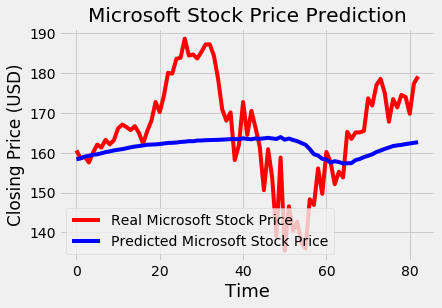

In [21]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Microsoft Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Microsoft Stock Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()